In [ ]:
# copy untitled->test vae
# run on gauss
# do cuda
# test against simple vae
# do for multiple channels

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import math
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# https://github.com/ducha-aiki/ucn-pytorch/blob/master/Utils.py

In [71]:
def gauss_kernel2(k_size=5, sigma=1.0):
    if k_size % 2 != 1:
        raise ValueError("kernel size must be uneven")
    
    x = np.linspace(- k_size / 2, k_size / 2, k_size)
    xv, yv = np.meshgrid(x, x, sparse=False, indexing='xy')
    distsq = (xv)**2 + (yv)**2
    denom = 2.0 * sigma ** 2
    kernel = np.exp(-distsq / denom)
    kernel /= np.sum(kernel)
    return kernel


def gauss_kernel3(k_size=5, sigma=1.0):
    if k_size % 2 != 1:
        raise ValueError("kernel size must be uneven")
    
    x = torch.linspace(- k_size / 2, k_size / 2, k_size)
    grid = torch.stack([x.repeat(k_size, 1).t().contiguous().view(-1), x.repeat(k_size)], 1)

    distsq = torch.pow(grid[:, 0], 2) + torch.pow(grid[:, 1], 2)
    denom = torch.pow(torch.Tensor([sigma]), 2) * 2.0
    kernel = torch.exp(- distsq / denom)
    kernel /= torch.sum(kernel)
    kernel = torch.reshape(kernel, (k_size, k_size))
    return kernel


def log_kernel(k_size=5, sigma=1.0):

    x = torch.linspace(- k_size / 2, k_size / 2, k_size)
    grid = torch.stack([x.repeat(k_size, 1).t().contiguous().view(-1), x.repeat(k_size)], 1)

    distsq = torch.pow(grid[:, 0], 2) + torch.pow(grid[:, 1], 2)

    gauss_denom = torch.pow(torch.Tensor([sigma]), 2) * 2.0
    gauss_kernel = torch.exp(- distsq / gauss_denom)

    nom = (distsq - (torch.pow(torch.Tensor([sigma]), 2) * 2.0)) * gauss_kernel
    denom = torch.pow(torch.Tensor([sigma]), 4) * torch.sum(gauss_kernel)
    kernel = nom / denom
    kernel = torch.reshape(kernel, (k_size, k_size))
    return kernel

torch.Size([1, 1, 768, 1024])


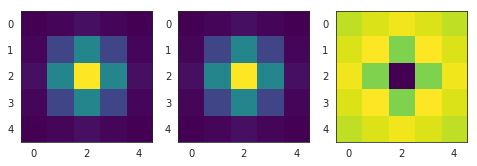

In [9]:
from scipy import misc
im = misc.face()[:, :, 0]
im = torch.from_numpy(im[np.newaxis, np.newaxis, :, :])
print(im.size())

n_batch, n_channel, h, w = im.shape
kernel2 = gauss_kernel2()
kernel3 = gauss_kernel3()
kernel4 = log_kernel()

plt.rcParams['figure.figsize'] = 8, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=1, ncols=3)
    
    axis[0].imshow(kernel2, cmap='viridis')
    axis[0].set_title('')
    
    axis[1].imshow(kernel3.cpu().numpy(), cmap='viridis')
    axis[1].set_title('')
    
    axis[2].imshow(kernel4.cpu().numpy(), cmap='viridis')
    axis[2].set_title('')

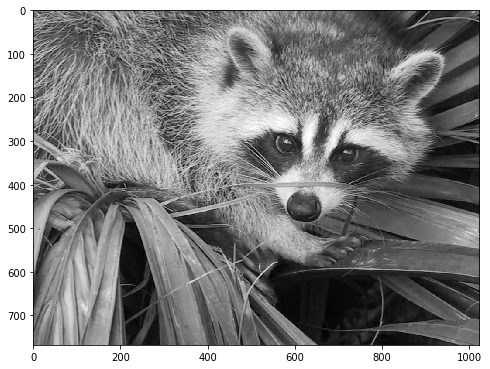

In [10]:
from scipy import misc
im = misc.face()[:, :, 0]
plt.imshow(im, cmap='gray')

In [72]:
kw, kh = 15, 15
k_size=15
sigma=4.0

kernel = gauss_kernel3(k_size, sigma)
kernel = kernel.unsqueeze(0).unsqueeze(0)

im_org = misc.face()[:, :, 0]
n_channels = 1
im = torch.from_numpy(im_org[np.newaxis, np.newaxis, :, :]).type(torch.FloatTensor)
f_pad = nn.ReplicationPad2d((kw // 2, kw // 2, kh // 2, kh // 2))
im = f_pad(im)
# img = F.pad(im, (0, 0, kw // 2, kh // 2), mode='replicate')
conv_img = F.conv2d(im, kernel)

current_img = F.avg_pool2d(conv_img, 2)

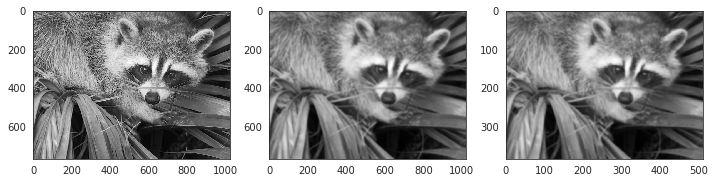

In [53]:
plt.rcParams['figure.figsize'] = 12, 12
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=1, ncols=3)
    
    axis[0].imshow(im_org, cmap='gray')
    axis[0].set_title('')
    
    axis[1].imshow(conv_img.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    axis[1].set_title('')
    
    axis[2].imshow(current_img.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    axis[2].set_title('')

In [110]:
def gauss_kernel(k_size=5, sigma=1.0):
    if k_size % 2 != 1:
        raise ValueError("kernel size must be uneven")

    x = torch.linspace(- k_size / 2, k_size / 2, k_size)
    grid = torch.stack([x.repeat(k_size, 1).t().contiguous().view(-1), x.repeat(k_size)], 1)

    distsq = torch.pow(grid[:, 0], 2) + torch.pow(grid[:, 1], 2)
    denom = torch.pow(torch.Tensor([sigma]), 2) * 2.0
    kernel = torch.exp(- distsq / denom)
    kernel /= torch.sum(kernel)
    kernel = torch.reshape(kernel, (k_size, k_size))
    return kernel


def dog_pyramid(im, n_levels=5, k_size=15, sigma=4.0):

    kernel = gauss_kernel(k_size, sigma)
    kernel = kernel.unsqueeze(0).unsqueeze(0)

    func_pad = nn.ReplicationPad2d((k_size // 2, k_size // 2, k_size // 2, k_size // 2))
    curr_im = im
    n_levels = 5
    log_pyr = []
    for i in range(n_levels):
        conv_im = F.conv2d(func_pad(curr_im), kernel)
        diff = curr_im - conv_im
        log_pyr.append(diff)
        curr_im = F.avg_pool2d(conv_im, 2)

    return log_pyr


def loss_dog(im1, im2, n_levels=5, k_size=5, sigma=2.0):
    pyramid_im1 = dog_pyramid(im1, n_levels, k_size, sigma)
    pyramid_im2 = dog_pyramid(im2, n_levels, k_size, sigma)
    return sum(F.l1_loss(a, b) for a, b in zip(pyramid_im1, pyramid_im2)) / n_levels

In [113]:
im_org = misc.face()[:, :, 0]
im1 = torch.from_numpy(im_org[np.newaxis, np.newaxis, :, :]).type(torch.FloatTensor)
im2 = torch.from_numpy(im_org[np.newaxis, np.newaxis, :, :]).type(torch.FloatTensor)
im2 = im2 + torch.randn_like(im2)

log_pyr = log_pyramid(im1)

loss_lap = loss_laplacian(im1, im2, 5, 15, 4.0)
print('L1 laplacian loss {}'.format(loss_lap))

L1 laplacian loss 0.17480354011058807


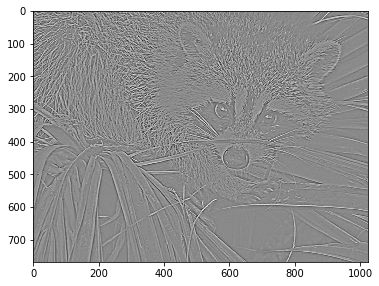

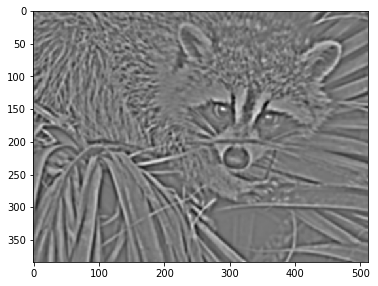

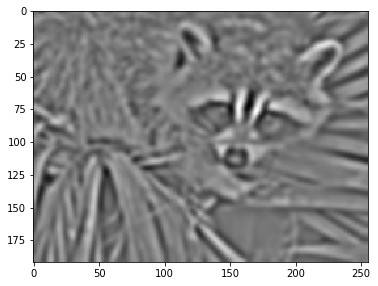

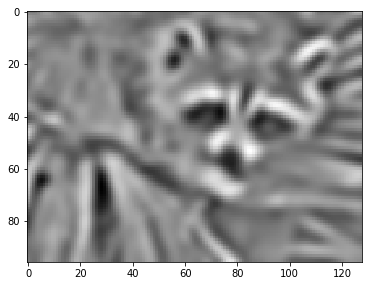

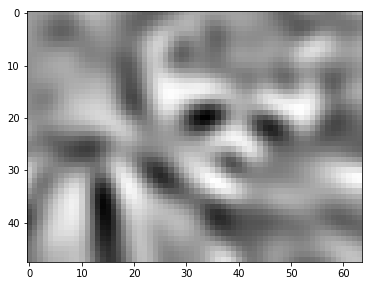

In [109]:
plt.rcParams['figure.figsize'] = 6, 6
for t_im in log_pyr:
    plt.imshow(t_im.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    plt.show()

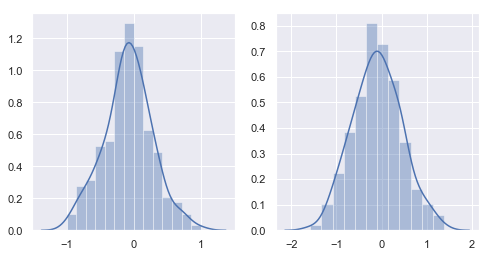

In [149]:
def normalize(x):
    min_x = np.min(x)
    max_x = np.max(x)
    return -1 + (2.0 / (max_x - min_x) * (x - min_x))

x = np.random.randn(200)
xn = normalize(x)

z = np.random.randn(200) * 0.1
z = normalize(z)
y = xn + z

plt.rcParams['figure.figsize'] = 8, 4
sns.set()
fig, axis = plt.subplots(nrows=1, ncols=2)    
sns.distplot(xn, ax = axis[0])
sns.distplot(y, ax = axis[1])


In [156]:
a = torch.randn(150, 10)
b = torch.randn(150, 10) * 2.5 + 4

labels = np.hstack((np.ones(150, ), np.zeros(150, )))
x = torch.cat((a, b))
bx = torch.stack((a, b), dim=0)

In [146]:
bx.size()

torch.Size([2, 150, 10])

In [148]:
def pca_project(x, num_elem=2):

    if isinstance(x, torch.Tensor) and len(x.size()) == 3:
        batch_proj = []
        for batch_ind in range(x.size(0)):
            tensor_proj = pca_project(x[batch_ind].squeeze(0), num_elem)
            batch_proj.append(tensor_proj)
        return torch.cat(batch_proj)
    
    xm = x - torch.mean(x, 1, keepdim=True)
    xx = torch.matmul(xm, torch.transpose(xm, 0, -1))
    u, s, _ = torch.svd(xx)
    x_proj = torch.matmul(u[:, 0:num_elem], torch.diag(s[0:num_elem]))
    return x_proj

In [149]:
x_proj = pca_project(x, 2)
xb_proj = pca_project(bx, 2)



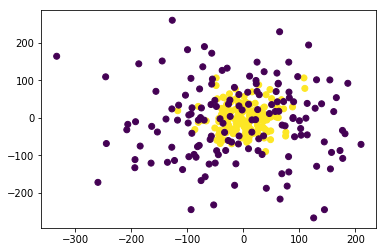

In [159]:
plt.scatter(x_proj[:, 0], x_proj[:, 1], c=labels)
plt.show()

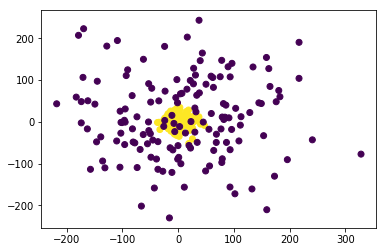

In [160]:
plt.scatter(xb_proj[:, 0], xb_proj[:, 1], c=labels)
plt.show()